In [76]:
#Import Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Change Working Directory
os.chdir(r'C:\Users\malva\Thesis')

#Read data file
data = pd.read_csv('Files\Samples\ValdAran_Sample.csv')
data.head()

,lat,long,elevation,slope,aspect,curv_plan,curv_prof,facc,twi,soil,lulc,rain_ant,rain_event,pof_event,pof_dry,pof_sat,response
0,4738872.5,311597.5,790.80,13.145604,327.05750,0.025769,-0.010359,1.397940,4.673251,2.0,3.0,0.5,49.0,0.0000,0.0000,1.0000,1.0
1,4738862.5,311617.5,794.77,18.441340,307.93506,-0.117006,-0.044545,2.352183,6.514342,2.0,3.0,0.5,49.0,0.0000,0.0000,1.0000,1.0
2,4738697.5,319872.5,1709.36,43.968290,173.81042,0.000644,0.018706,2.889302,6.688886,8.0,1.0,0.5,70.0,0.8803,0.3543,0.1197,1.0
3,4737832.5,318912.5,1285.22,47.644943,194.89754,0.076285,0.069331,0.000000,-11.605381,8.0,1.0,0.5,69.0,0.6894,0.5387,0.1381,1.0
4,4737377.5,317017.5,1734.32,39.489166,182.85223,-0.000287,-0.003942,3.122216,7.382731,8.0,1.0,0.5,67.0,0.6695,0.0711,0.3305,1.0


In [2]:
print('Soil: ' + str(sorted(data['soil'].unique())))
print('LULC: ' + str(sorted(data['lulc'].unique())))

Soil: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
LULC: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0]


In [3]:
#Encoding Categorical with Pandas
X = pd.get_dummies(data, columns = ['soil', 'lulc'])
X = X.drop(columns=['lat', 'long', 'elevation', 'response'])

In [4]:
#Complete missing columns
X['lulc_7.0'] = 0
X['lulc_10.0'] = 0
X.sort_index(axis=1, inplace=True)
X.columns

Index(['aspect', 'curv_plan', 'curv_prof', 'facc', 'lulc_1.0', 'lulc_10.0',
       'lulc_2.0', 'lulc_3.0', 'lulc_4.0', 'lulc_5.0', 'lulc_6.0', 'lulc_7.0',
       'lulc_8.0', 'lulc_9.0', 'pof_dry', 'pof_event', 'pof_sat', 'rain_ant',
       'rain_event', 'slope', 'soil_1.0', 'soil_10.0', 'soil_11.0', 'soil_2.0',
       'soil_3.0', 'soil_4.0', 'soil_5.0', 'soil_6.0', 'soil_7.0', 'soil_8.0',
       'soil_9.0', 'twi'],
      dtype='object')

In [5]:
#Create inputs and outputs for the data-driven model
y = data['response'].values

In [6]:
# Split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
improvement_norain = pd.DataFrame(columns=['AUC ROC', 'Accuracy', 'FPR', 'FNR', 'MCC'])
improvement_rain = pd.DataFrame(columns=['AUC ROC', 'Accuracy', 'FPR', 'FNR', 'MCC'])

In [66]:
parameters_norain = ['rain_ant', 'rain_event']
parameters_rain = []

In [67]:
#Logistic Regression with Cross-validation (5-fold) and parameter optimization
#No Rainfall

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 

logreg_norain = LogisticRegression()
param_grid = {'max_iter' : [2500],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}
clf_norain = GridSearchCV(logreg_norain, param_grid = param_grid, scoring = 'roc_auc', n_jobs = -1, cv = 5)
best_logreg_norain = clf_norain.fit(X_train.drop(columns=parameters_norain), y_train)

results_norain = pd.DataFrame(clf_norain.cv_results_)
print('Best Score: ' + str(best_logreg_norain.best_score_))
print('Best Parameters: ' + str(best_logreg_norain.best_params_))

Best Score: 0.7988835946864259
Best Parameters: {'C': 0.23357214690901212, 'max_iter': 2500, 'penalty': 'l2', 'solver': 'liblinear'}


In [68]:
#Logistic Regression with Cross-validation (5-fold) and parameter optimization
#Rainfall

logreg_rain = LogisticRegression()
clf_rain = GridSearchCV(logreg_rain, param_grid = param_grid, scoring = 'roc_auc', n_jobs = -1, cv = 5)
best_logreg_rain = clf_rain.fit(X_train.drop(columns=parameters_rain), y_train)

results_rain = pd.DataFrame(clf_rain.cv_results_)
print('Best Score: ' + str(best_logreg_rain.best_score_))
print('Best Parameters: ' + str(best_logreg_rain.best_params_))

Best Score: 0.8061813390920168
Best Parameters: {'C': 0.615848211066026, 'max_iter': 2500, 'penalty': 'l2', 'solver': 'liblinear'}


In [69]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

#Logistic Regression

#No Rainfall
y_pred_prob_norain = best_logreg_norain.predict_proba(X_test.drop(columns=parameters_norain))[:, 1]

fpr_norain, tpr_norain, thresholds_norain = metrics.roc_curve(y_test, y_pred_prob_norain)
auc_norain = metrics.roc_auc_score(y_test, y_pred_prob_norain)

#Rainfall
y_pred_prob_rain = best_logreg_rain.predict_proba(X_test.drop(columns=parameters_rain))[:, 1]

fpr_rain, tpr_rain, thresholds_rain = metrics.roc_curve(y_test, y_pred_prob_rain)
auc_rain = metrics.roc_auc_score(y_test, y_pred_prob_rain)

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef

#No Rain
y_pred_norain = best_logreg_norain.predict(X_test.drop(columns=parameters_norain))
matrix_norain = confusion_matrix(y_test, y_pred_norain)
acc_norain = accuracy_score(y_test, y_pred_norain)
FP = matrix_norain[0,1]
TN = matrix_norain[0,0]
fpr_norain = FP/(FP+TN)
fnr_norain = 1 - recall_score(y_test, y_pred_norain)
mcc_norain = matthews_corrcoef(y_test, y_pred_norain)
stats_norain = '\n\nAccuracy = {:0.3f}\nFPR = {:0.3f}\nFNR = {:0.3f}\nMCC = {:0.3f}'.format(acc_norain, fpr_norain, fnr_norain, mcc_norain)


#No Rain
y_pred_rain = best_logreg_rain.predict(X_test.drop(columns=parameters_rain))
matrix_rain = confusion_matrix(y_test, y_pred_rain)
acc_rain = accuracy_score(y_test, y_pred_rain)
FP = matrix_rain[0,1]
TN = matrix_rain[0,0]
fpr_rain = FP/(FP+TN)
fnr_rain = 1 - recall_score(y_test, y_pred_rain)
mcc_rain = matthews_corrcoef(y_test, y_pred_rain)
stats_rain = '\n\nAccuracy = {:0.3f}\nFPR = {:0.3f}\nFNR = {:0.3f}\nMCC = {:0.3f}'.format(acc_rain, fpr_rain, fnr_rain, mcc_rain)

In [71]:
#Append Results

#No Rain
model_norain = 'No Rain + PoF_Dry + PoF_Event + PoF_Sat'
improvement_norain.loc[model_norain] = [auc_norain, acc_norain, fpr_norain, fnr_norain, mcc_norain]

#Rain
model_rain = 'Rain + PoF_Dry + PoF_Event + PoF_Sat'
improvement_rain.loc[model_rain] = [auc_rain, acc_rain, fpr_rain, fnr_rain, mcc_rain]

In [87]:
print(improvement_norain.round(3).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  AUC ROC &  Accuracy &    FPR &   FNR &    MCC \\
\midrule
No Rain                                 &    0.806 &     0.770 &  0.292 &  0.17 &  0.543 \\
No Rain + PoF\_Dry                       &    0.806 &     0.770 &  0.292 &  0.17 &  0.543 \\
No Rain + PoF\_Event                     &    0.818 &     0.750 &  0.271 &  0.23 &  0.500 \\
No Rain + PoF\_Sat                       &    0.824 &     0.735 &  0.312 &  0.22 &  0.470 \\
No Rain + PoF\_Dry + PoF\_Event           &    0.819 &     0.750 &  0.271 &  0.23 &  0.500 \\
No Rain + PoF\_Dry + PoF\_Sat             &    0.824 &     0.735 &  0.312 &  0.22 &  0.470 \\
No Rain + PoF\_Event + PoF\_Sat           &    0.820 &     0.719 &  0.302 &  0.26 &  0.438 \\
No Rain + PoF\_Dry + PoF\_Event + PoF\_Sat &    0.823 &     0.730 &  0.302 &  0.24 &  0.459 \\
\bottomrule
\end{tabular}



In [86]:
print(improvement_rain.round(3).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  AUC ROC &  Accuracy &    FPR &   FNR &    MCC \\
\midrule
Rain                                 &    0.800 &     0.740 &  0.292 &  0.23 &  0.479 \\
Rain + PoF\_Dry                       &    0.807 &     0.730 &  0.312 &  0.23 &  0.459 \\
Rain + PoF\_Event                     &    0.807 &     0.724 &  0.260 &  0.29 &  0.450 \\
Rain + PoF\_Sat                       &    0.823 &     0.740 &  0.302 &  0.22 &  0.480 \\
Rain + PoF\_Dry + PoF\_Event           &    0.810 &     0.709 &  0.292 &  0.29 &  0.418 \\
Rain + PoF\_Dry + PoF\_Sat             &    0.826 &     0.745 &  0.292 &  0.22 &  0.490 \\
Rain + PoF\_Event + PoF\_Sat           &    0.822 &     0.724 &  0.281 &  0.27 &  0.449 \\
Rain + PoF\_Dry + PoF\_Event + PoF\_Sat &    0.824 &     0.745 &  0.271 &  0.24 &  0.489 \\
\bottomrule
\end{tabular}



(0.7, 0.78)

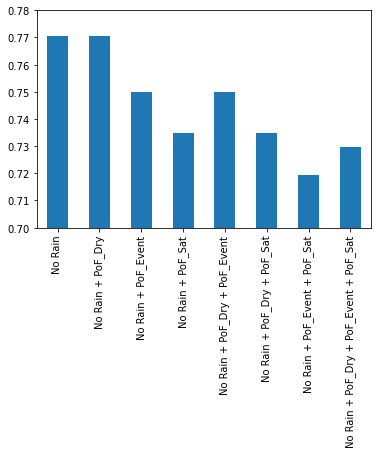

In [83]:
improvement_norain['Accuracy'].plot(kind='bar')
plt.ylim(0.70, 0.78)